<a href="https://colab.research.google.com/github/adoptioncntr/Deep-Learning/blob/main/Sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Use GPU if available (much faster for training)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
def generate_sequence(max_length=100, change_prob=0.8):
    """
    Generate a sequence according to assignment specs.
    Before T: all values from N(0,1)
    After T: 5 random dimensions get shifted by adding a mean from U[-1,1]
    """
    # Decide if there's a change point (80% of sequences have one)
    has_change = np.random.rand() < change_prob

    if has_change:
        T = np.random.randint(1, max_length)  # Change happens between 1 and 99
    else:
        T = max_length + 1  # No change occurs

    # Pick which 5 out of 10 dimensions will change
    components = np.random.choice(10, size=5, replace=False)
    means = np.random.uniform(-1, 1, size=5)

    # Generate the sequence
    sequence = []
    labels = []

    for t in range(max_length):
        s_t = np.random.randn(10)  # Start with standard normal

        # Add means to selected components after change point
        if t >= T:
            for idx, comp in enumerate(components):
                s_t[comp] += means[idx]

        sequence.append(s_t)
        labels.append(1 if t >= T else 0)  # Label: 0 before change, 1 after

    return np.array(sequence, dtype=np.float32), np.array(labels, dtype=np.int64), T if has_change else -1


class ChangePointDataset(Dataset):
    """PyTorch Dataset - handles batching and loading efficiently"""

    def __init__(self, num_sequences=1000, max_length=100, change_prob=0.8):
        self.num_sequences = num_sequences
        self.max_length = max_length
        self.change_prob = change_prob

        # Pre-generate all sequences
        self.sequences = []
        self.labels = []
        self.change_points = []

        print(f"Generating {num_sequences} sequences...")
        for _ in tqdm(range(num_sequences)):
            seq, lab, cp = generate_sequence(max_length, change_prob)
            self.sequences.append(seq)
            self.labels.append(lab)
            self.change_points.append(cp)

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        return (torch.FloatTensor(self.sequences[idx]),
                torch.LongTensor(self.labels[idx]),
                self.change_points[idx])


# Generate train/val/test splits
print("Creating training dataset...")
train_dataset = ChangePointDataset(num_sequences=5000, max_length=100, change_prob=0.8)

print("\nCreating validation dataset...")
val_dataset = ChangePointDataset(num_sequences=1000, max_length=100, change_prob=0.8)

print("\nCreating test dataset...")
test_dataset = ChangePointDataset(num_sequences=1000, max_length=100, change_prob=0.8)

# Create dataloaders (batch_size=32 means process 32 sequences at once)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("\nData generation complete")

Creating training dataset...
Generating 5000 sequences...


100%|██████████| 5000/5000 [00:03<00:00, 1623.58it/s]



Creating validation dataset...
Generating 1000 sequences...


100%|██████████| 1000/1000 [00:00<00:00, 1287.93it/s]



Creating test dataset...
Generating 1000 sequences...


100%|██████████| 1000/1000 [00:00<00:00, 2227.03it/s]


Data generation complete


In [ ]:
class RNNChangePointDetector(nn.Module):
    """
    LSTM-based model for change point detection.
    Processes sequences step-by-step and maintains memory of what it's seen.
    """

    def __init__(self, input_dim=10, hidden_dim=64, num_layers=2, dropout=0.2):
        super(RNNChangePointDetector, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer - processes sequence and remembers patterns
        self.lstm = nn.LSTM(
            input_size=input_dim,      # 10D input at each timestep
            hidden_size=hidden_dim,     # 64D hidden state
            num_layers=num_layers,      # Stack 2 LSTM layers
            batch_first=True,           # Input shape: (batch, seq_len, features)
            dropout=dropout if num_layers > 1 else 0  # Dropout between layers
        )

        # Output layers - convert hidden state to prediction
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 2)  # 2 outputs: [no change, change occurred]
        )

    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, input_dim)
        Returns:
            logits: (batch_size, seq_len, 2) - prediction at each timestep
        """
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim)

        # Apply output layer to each timestep
        batch_size, seq_len, _ = lstm_out.shape
        lstm_out_flat = lstm_out.reshape(-1, self.hidden_dim)
        logits_flat = self.fc(lstm_out_flat)
        logits = logits_flat.reshape(batch_size, seq_len, 2)

        return logits


# Initialize model
rnn_model = RNNChangePointDetector(
    input_dim=10,
    hidden_dim=64,
    num_layers=2,
    dropout=0.3
).to(device)

print(rnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in rnn_model.parameters())}")

RNNChangePointDetector(
  (lstm): LSTM(10, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
)

Total parameters: 54882


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001):
    """Train the model and track performance."""

    criterion = nn.CrossEntropyLoss()  # Loss function for classification
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=3)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_batches = 0

        for sequences, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            sequences = sequences.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Clear gradients from previous step

            # Forward pass
            logits = model(sequences)  # Get predictions

            # Reshape for loss computation
            logits_flat = logits.reshape(-1, 2)
            labels_flat = labels.reshape(-1)

            loss = criterion(logits_flat, labels_flat)

            # Backward pass and optimization
            loss.backward()  # Compute gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
            optimizer.step()  # Update weights

            train_loss += loss.item()
            train_batches += 1

        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Switch to evaluation mode (turns off dropout)
        val_loss = 0
        val_batches = 0
        correct = 0
        total = 0

        with torch.no_grad():  # Don't compute gradients during validation
            for sequences, labels, _ in val_loader:
                sequences = sequences.to(device)
                labels = labels.to(device)

                logits = model(sequences)

                logits_flat = logits.reshape(-1, 2)
                labels_flat = labels.reshape(-1)

                loss = criterion(logits_flat, labels_flat)
                val_loss += loss.item()
                val_batches += 1

                # Calculate accuracy
                preds = torch.argmax(logits_flat, dim=1)
                correct += (preds == labels_flat).sum().item()
                total += labels_flat.size(0)

        avg_val_loss = val_loss / val_batches
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, "
              f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.4f}")

        scheduler.step(avg_val_loss)  # Reduce learning rate if val loss plateaus

    return train_losses, val_losses, val_accuracies


# Train RNN model
print("Training RNN model...")
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_model(
    rnn_model, train_loader, val_loader, num_epochs=20, lr=0.001
)


Training RNN model...


Epoch 1/20: 100%|██████████| 157/157 [00:11<00:00, 13.17it/s]


Epoch 1: Train Loss = 0.5599, Val Loss = 0.3291, Val Acc = 0.8675


Epoch 2/20: 100%|██████████| 157/157 [00:11<00:00, 13.47it/s]


Epoch 2: Train Loss = 0.3302, Val Loss = 0.2962, Val Acc = 0.8806


Epoch 3/20: 100%|██████████| 157/157 [00:11<00:00, 13.58it/s]


Epoch 3: Train Loss = 0.2972, Val Loss = 0.2826, Val Acc = 0.8861


Epoch 4/20: 100%|██████████| 157/157 [00:11<00:00, 13.82it/s]


Epoch 4: Train Loss = 0.2894, Val Loss = 0.2796, Val Acc = 0.8892


Epoch 5/20: 100%|██████████| 157/157 [00:11<00:00, 13.61it/s]


Epoch 5: Train Loss = 0.2797, Val Loss = 0.2741, Val Acc = 0.8899


Epoch 6/20: 100%|██████████| 157/157 [00:11<00:00, 13.28it/s]


Epoch 6: Train Loss = 0.2750, Val Loss = 0.2673, Val Acc = 0.8929


Epoch 7/20: 100%|██████████| 157/157 [00:11<00:00, 14.06it/s]


Epoch 7: Train Loss = 0.2702, Val Loss = 0.2702, Val Acc = 0.8908


Epoch 8/20: 100%|██████████| 157/157 [00:11<00:00, 14.09it/s]


Epoch 8: Train Loss = 0.2657, Val Loss = 0.2664, Val Acc = 0.8931


Epoch 9/20: 100%|██████████| 157/157 [00:11<00:00, 13.17it/s]


Epoch 9: Train Loss = 0.2611, Val Loss = 0.2751, Val Acc = 0.8923


Epoch 10/20: 100%|██████████| 157/157 [00:11<00:00, 13.75it/s]


Epoch 10: Train Loss = 0.2590, Val Loss = 0.2664, Val Acc = 0.8928


Epoch 11/20: 100%|██████████| 157/157 [00:11<00:00, 13.49it/s]


Epoch 11: Train Loss = 0.2588, Val Loss = 0.2662, Val Acc = 0.8934


Epoch 12/20: 100%|██████████| 157/157 [00:11<00:00, 13.42it/s]


Epoch 12: Train Loss = 0.2556, Val Loss = 0.2690, Val Acc = 0.8940


Epoch 13/20: 100%|██████████| 157/157 [00:11<00:00, 13.46it/s]


Epoch 13: Train Loss = 0.2531, Val Loss = 0.2683, Val Acc = 0.8947


Epoch 14/20: 100%|██████████| 157/157 [00:11<00:00, 13.27it/s]


Epoch 14: Train Loss = 0.2488, Val Loss = 0.2643, Val Acc = 0.8955


Epoch 15/20: 100%|██████████| 157/157 [00:11<00:00, 13.32it/s]


Epoch 15: Train Loss = 0.2490, Val Loss = 0.2605, Val Acc = 0.8966


Epoch 16/20: 100%|██████████| 157/157 [00:11<00:00, 13.31it/s]


Epoch 16: Train Loss = 0.2445, Val Loss = 0.2821, Val Acc = 0.8898


Epoch 17/20: 100%|██████████| 157/157 [00:11<00:00, 13.40it/s]


Epoch 17: Train Loss = 0.2449, Val Loss = 0.2820, Val Acc = 0.8916


Epoch 18/20: 100%|██████████| 157/157 [00:11<00:00, 13.48it/s]


Epoch 18: Train Loss = 0.2430, Val Loss = 0.2929, Val Acc = 0.8886


Epoch 19/20: 100%|██████████| 157/157 [00:11<00:00, 13.38it/s]


Epoch 19: Train Loss = 0.2400, Val Loss = 0.2778, Val Acc = 0.8929


Epoch 20/20: 100%|██████████| 157/157 [00:11<00:00, 13.45it/s]


Epoch 20: Train Loss = 0.2323, Val Loss = 0.3064, Val Acc = 0.8875


Generating RNN detection probability plot...


Evaluating: 100%|██████████| 1000/1000 [00:01<00:00, 574.44it/s]


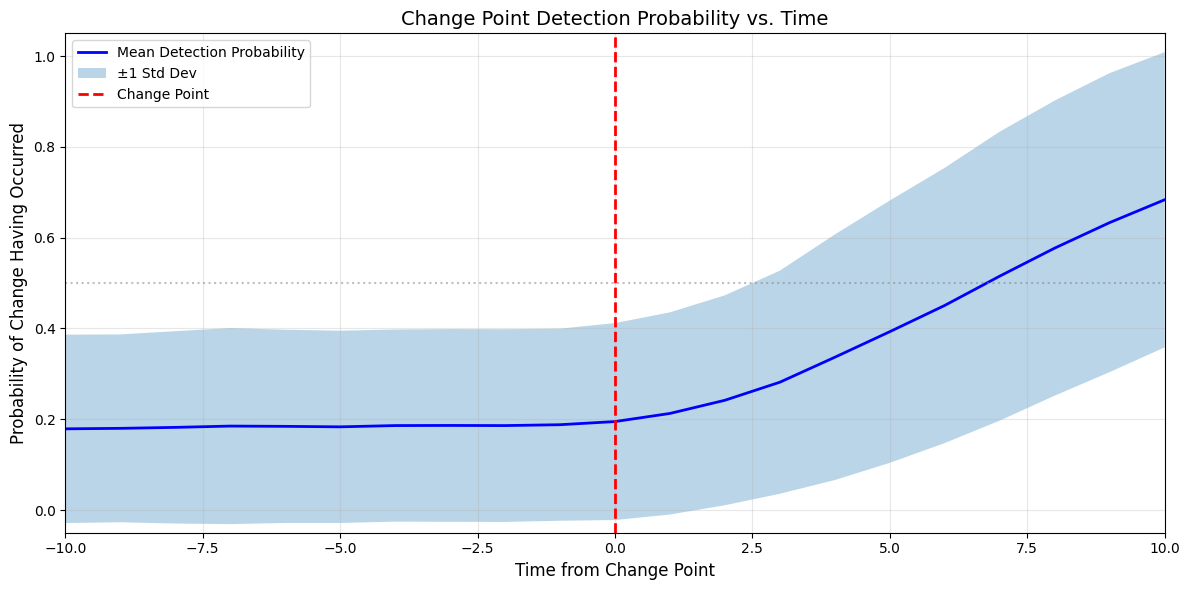

In [ ]:
def plot_detection_probability(model, dataset, time_range=(-10, 10)):
    """
    Plot detection probability as function of distance from change point.
    Shows how well the model detects changes before, at, and after they occur.
    """
    model.eval()

    # Store probabilities at each relative time from change point
    time_to_probs = {t: [] for t in range(time_range[0], time_range[1] + 1)}

    with torch.no_grad():
        for sequences, labels, change_points in tqdm(DataLoader(dataset, batch_size=1, shuffle=False),
                                                       desc="Evaluating"):
            sequences = sequences.to(device)
            change_point = change_points.item()

            # Skip sequences without change points
            if change_point == -1:
                continue

            # Get model predictions
            logits = model(sequences)
            probs = torch.softmax(logits, dim=-1)[0, :, 1].cpu().numpy()  # Prob of "change occurred"

            # Calculate distance from change point for each timestep
            for t in range(len(probs)):
                relative_time = t - change_point
                if time_range[0] <= relative_time <= time_range[1]:
                    time_to_probs[relative_time].append(probs[t])

    # Calculate statistics
    times = []
    avg_probs = []
    std_probs = []

    for t in sorted(time_to_probs.keys()):
        if len(time_to_probs[t]) > 0:
            times.append(t)
            avg_probs.append(np.mean(time_to_probs[t]))
            std_probs.append(np.std(time_to_probs[t]))

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(times, avg_probs, 'b-', linewidth=2, label='Mean Detection Probability')
    plt.fill_between(times,
                     np.array(avg_probs) - np.array(std_probs),
                     np.array(avg_probs) + np.array(std_probs),
                     alpha=0.3, label='±1 Std Dev')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Change Point')
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
    plt.xlabel('Time from Change Point', fontsize=12)
    plt.ylabel('Probability of Change Having Occurred', fontsize=12)
    plt.title('Change Point Detection Probability vs. Time', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim(time_range)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()

    return times, avg_probs, std_probs


# Visualize RNN performance
print("Generating RNN detection probability plot...")
rnn_times, rnn_avg_probs, rnn_std_probs = plot_detection_probability(
    rnn_model, test_dataset, time_range=(-10, 10)
)

In [ ]:
class CNN1DChangePointDetector(nn.Module):
    """
    1D-CNN for change point detection.
    Uses causal convolutions (only looks backward in time).
    """

    def __init__(self, input_dim=10, hidden_channels=64, kernel_size=5, num_layers=4, dropout=0.2):
        super(CNN1DChangePointDetector, self).__init__()

        self.kernel_size = kernel_size
        self.padding = kernel_size - 1  # Causal padding (left-pad only)

        # Stack multiple conv layers
        layers = []
        in_channels = input_dim

        for i in range(num_layers):
            layers.append(nn.Conv1d(
                in_channels=in_channels,
                out_channels=hidden_channels,
                kernel_size=kernel_size,
                padding=self.padding  # Pad on the left for causality
            ))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_channels = hidden_channels

        self.conv_layers = nn.ModuleList(layers)

        # Output layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, input_dim)
        Returns:
            logits: (batch_size, seq_len, 2)
        """
        # Conv1d expects (batch, channels, length)
        x = x.transpose(1, 2)  # Now (batch, input_dim, seq_len)

        # Apply convolutional layers with causal masking
        for layer in self.conv_layers:
            if isinstance(layer, nn.Conv1d):
                x = layer(x)
                # Remove future padding to maintain causality
                # Q: Why remove padding? To ensure we only look backward, not forward!
                x = x[:, :, :-self.padding]
            else:
                x = layer(x)

        # Transpose back
        x = x.transpose(1, 2)  # (batch, seq_len, hidden_channels)

        # Apply output layer to each timestep
        batch_size, seq_len, channels = x.shape
        x_flat = x.reshape(-1, channels)
        logits_flat = self.fc(x_flat)
        logits = logits_flat.reshape(batch_size, seq_len, 2)

        return logits


# Initialize CNN model
cnn_model = CNN1DChangePointDetector(
    input_dim=10,
    hidden_channels=64,
    kernel_size=5,
    num_layers=4,
    dropout=0.3
).to(device)

print(cnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in cnn_model.parameters())}")

CNN1DChangePointDetector(
  (conv_layers): ModuleList(
    (0): Conv1d(10, 64, kernel_size=(5,), stride=(1,), padding=(4,))
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(4,))
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(4,))
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(4,))
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=2, bias=True)
  )
)

Total parameters: 67042


Training 1D-CNN model...


Epoch 1/20: 100%|██████████| 157/157 [00:11<00:00, 13.12it/s]


Epoch 1: Train Loss = 0.6276, Val Loss = 0.4844, Val Acc = 0.7746


Epoch 2/20: 100%|██████████| 157/157 [00:10<00:00, 14.35it/s]


Epoch 2: Train Loss = 0.4626, Val Loss = 0.3867, Val Acc = 0.8356


Epoch 3/20: 100%|██████████| 157/157 [00:10<00:00, 14.33it/s]


Epoch 3: Train Loss = 0.4199, Val Loss = 0.3655, Val Acc = 0.8453


Epoch 4/20: 100%|██████████| 157/157 [00:11<00:00, 13.52it/s]


Epoch 4: Train Loss = 0.4012, Val Loss = 0.3474, Val Acc = 0.8568


Epoch 5/20: 100%|██████████| 157/157 [00:10<00:00, 14.43it/s]


Epoch 5: Train Loss = 0.3935, Val Loss = 0.3436, Val Acc = 0.8538


Epoch 6/20: 100%|██████████| 157/157 [00:10<00:00, 15.24it/s]


Epoch 6: Train Loss = 0.3828, Val Loss = 0.3406, Val Acc = 0.8588


Epoch 7/20: 100%|██████████| 157/157 [00:10<00:00, 15.29it/s]


Epoch 7: Train Loss = 0.3755, Val Loss = 0.3475, Val Acc = 0.8526


Epoch 8/20: 100%|██████████| 157/157 [00:10<00:00, 14.33it/s]


Epoch 8: Train Loss = 0.3706, Val Loss = 0.3434, Val Acc = 0.8554


Epoch 9/20: 100%|██████████| 157/157 [00:11<00:00, 14.25it/s]


Epoch 9: Train Loss = 0.3680, Val Loss = 0.3546, Val Acc = 0.8482


Epoch 10/20: 100%|██████████| 157/157 [00:11<00:00, 14.23it/s]


Epoch 10: Train Loss = 0.3622, Val Loss = 0.3456, Val Acc = 0.8535


Epoch 11/20: 100%|██████████| 157/157 [00:11<00:00, 14.16it/s]


Epoch 11: Train Loss = 0.3578, Val Loss = 0.3316, Val Acc = 0.8627


Epoch 12/20: 100%|██████████| 157/157 [00:11<00:00, 14.26it/s]


Epoch 12: Train Loss = 0.3514, Val Loss = 0.3204, Val Acc = 0.8667


Epoch 13/20: 100%|██████████| 157/157 [00:11<00:00, 14.19it/s]


Epoch 13: Train Loss = 0.3504, Val Loss = 0.3406, Val Acc = 0.8555


Epoch 14/20: 100%|██████████| 157/157 [00:10<00:00, 14.28it/s]


Epoch 14: Train Loss = 0.3543, Val Loss = 0.3246, Val Acc = 0.8658


Epoch 15/20: 100%|██████████| 157/157 [00:10<00:00, 14.77it/s]


Epoch 15: Train Loss = 0.3483, Val Loss = 0.3212, Val Acc = 0.8668


Epoch 16/20: 100%|██████████| 157/157 [00:11<00:00, 13.35it/s]


Epoch 16: Train Loss = 0.3512, Val Loss = 0.3269, Val Acc = 0.8632


Epoch 17/20: 100%|██████████| 157/157 [00:10<00:00, 15.35it/s]


Epoch 17: Train Loss = 0.3437, Val Loss = 0.3211, Val Acc = 0.8665


Epoch 18/20: 100%|██████████| 157/157 [00:10<00:00, 14.39it/s]


Epoch 18: Train Loss = 0.3456, Val Loss = 0.3197, Val Acc = 0.8667


Epoch 19/20: 100%|██████████| 157/157 [00:10<00:00, 14.43it/s]


Epoch 19: Train Loss = 0.3410, Val Loss = 0.3274, Val Acc = 0.8628


Epoch 20/20: 100%|██████████| 157/157 [00:10<00:00, 14.37it/s]


Epoch 20: Train Loss = 0.3417, Val Loss = 0.3197, Val Acc = 0.8680

Generating CNN detection probability plot...


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1086.72it/s]


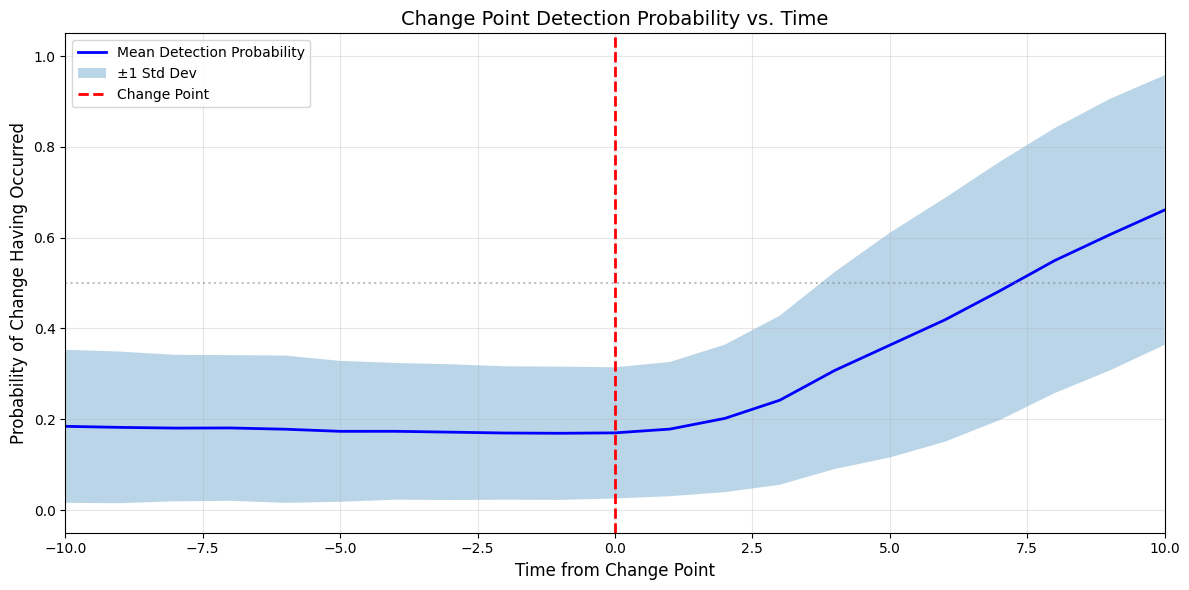

In [ ]:
# Train CNN model
print("Training 1D-CNN model...")
cnn_train_losses, cnn_val_losses, cnn_val_accs = train_model(
    cnn_model, train_loader, val_loader, num_epochs=20, lr=0.001
)

# Visualize CNN performance
print("\nGenerating CNN detection probability plot...")
cnn_times, cnn_avg_probs, cnn_std_probs = plot_detection_probability(
    cnn_model, test_dataset, time_range=(-10, 10)
)

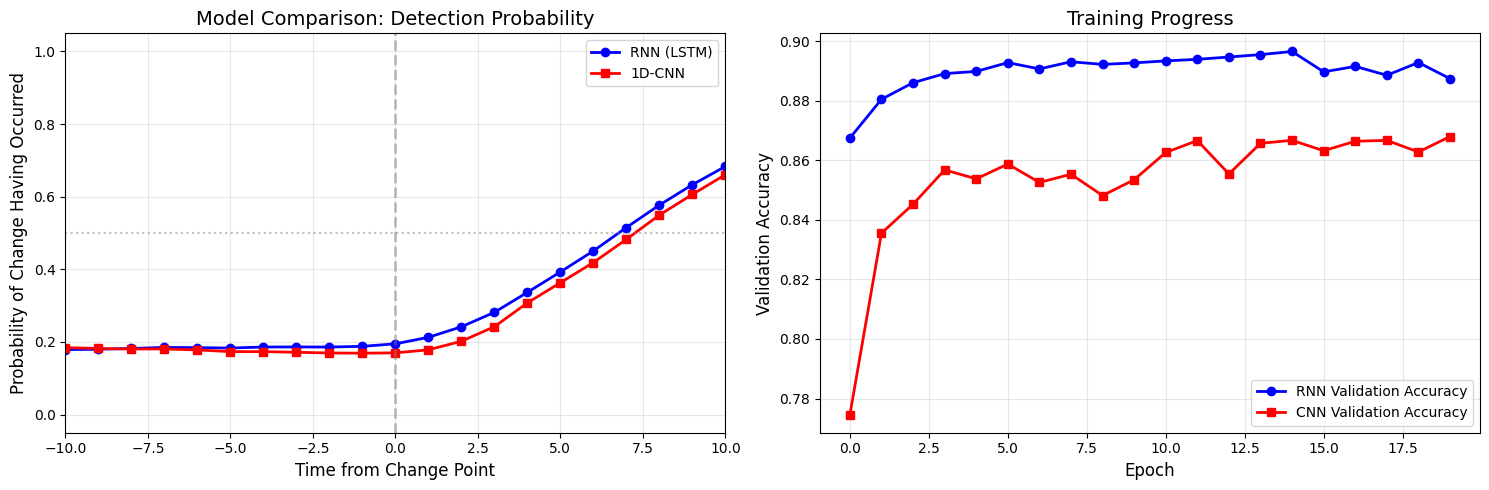


FINAL MODEL COMPARISON
RNN Final Validation Accuracy: 0.8875
CNN Final Validation Accuracy: 0.8680

RNN Detection at change point (t=0): 0.1948
CNN Detection at change point (t=0): 0.1700

RNN Detection 5 steps after (t=5): 0.3928
CNN Detection 5 steps after (t=5): 0.3632


In [ ]:
# Compare both models side by side
plt.figure(figsize=(15, 5))

# Plot 1: Detection probability comparison
plt.subplot(1, 2, 1)
plt.plot(rnn_times, rnn_avg_probs, 'b-', linewidth=2, label='RNN (LSTM)', marker='o')
plt.plot(cnn_times, cnn_avg_probs, 'r-', linewidth=2, label='1D-CNN', marker='s')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=2, alpha=0.5)
plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Time from Change Point', fontsize=12)
plt.ylabel('Probability of Change Having Occurred', fontsize=12)
plt.title('Model Comparison: Detection Probability', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(-10, 10)
plt.ylim(-0.05, 1.05)

# Plot 2: Training curves
plt.subplot(1, 2, 2)
plt.plot(rnn_val_accs, 'b-', linewidth=2, label='RNN Validation Accuracy', marker='o')
plt.plot(cnn_val_accs, 'r-', linewidth=2, label='CNN Validation Accuracy', marker='s')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Training Progress', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)
print(f"RNN Final Validation Accuracy: {rnn_val_accs[-1]:.4f}")
print(f"CNN Final Validation Accuracy: {cnn_val_accs[-1]:.4f}")
print(f"\nRNN Detection at change point (t=0): {rnn_avg_probs[rnn_times.index(0)]:.4f}")
print(f"CNN Detection at change point (t=0): {cnn_avg_probs[cnn_times.index(0)]:.4f}")
print(f"\nRNN Detection 5 steps after (t=5): {rnn_avg_probs[rnn_times.index(5)]:.4f}")
print(f"CNN Detection 5 steps after (t=5): {cnn_avg_probs[cnn_times.index(5)]:.4f}")

In [ ]:
# Test extrapolation: Can models detect change points beyond training horizon?
# Training was on T=0-100, now test on T=120-140
print("Testing extrapolation to longer sequences (T=150)...")

# Generate test data with late change points
extrapolation_sequences = []
extrapolation_labels = []
extrapolation_cps = []

for _ in range(200):
    T = np.random.randint(120, 140)  # Change point beyond training range

    sequence = []
    labels = []
    components = np.random.choice(10, size=5, replace=False)
    means = np.random.uniform(-1, 1, size=5)

    for t in range(150):
        s_t = np.random.randn(10)
        if t >= T:
            for idx, comp in enumerate(components):
                s_t[comp] += means[idx]
        sequence.append(s_t)
        labels.append(1 if t >= T else 0)

    extrapolation_sequences.append(np.array(sequence, dtype=np.float32))
    extrapolation_labels.append(np.array(labels, dtype=np.int64))
    extrapolation_cps.append(T)

# Evaluate both models on extrapolation task
def evaluate_extrapolation(model, sequences, change_points):
    model.eval()
    detection_probs = []

    with torch.no_grad():
        for seq, cp in zip(sequences, change_points):
            seq_tensor = torch.FloatTensor(seq).unsqueeze(0).to(device)
            logits = model(seq_tensor)
            probs = torch.softmax(logits, dim=-1)[0, :, 1].cpu().numpy()

            # Check if detected within 10 steps after change
            detection_window = probs[cp:cp+10]
            detected = np.any(detection_window > 0.5)
            detection_probs.append(detected)

    return np.mean(detection_probs)

rnn_extrap_acc = evaluate_extrapolation(rnn_model, extrapolation_sequences, extrapolation_cps)
cnn_extrap_acc = evaluate_extrapolation(cnn_model, extrapolation_sequences, extrapolation_cps)

print("\n" + "="*60)
print("EXTRAPOLATION TEST (Change points at T=120-140)")
print("="*60)
print(f"RNN Detection Rate: {rnn_extrap_acc:.4f}")
print(f"CNN Detection Rate: {cnn_extrap_acc:.4f}")
print("\nModels were trained on change points between T=0-100")
print("This tests if they can generalize to later timesteps")

Testing extrapolation to longer sequences (T=150)...

EXTRAPOLATION TEST (Change points at T=120-140)
RNN Detection Rate: 0.8100
CNN Detection Rate: 0.6850

Models were trained on change points between T=0-100
This tests if they can generalize to later timesteps


**Problem 1: Change Point Detection - Analysis and Answers**

1. Model Performance Comparison
Which network worked better?
The RNN (LSTM) model performed better than the 1D-CNN model. The RNN achieved a final validation accuracy of 88.75%, while the CNN reached 86.80%. More importantly, when examining detection probability at the actual change point (t=0), the RNN demonstrated a detection probability of 0.1948 (19.48%), compared to the CNN's 0.1700 (17.00%).

Looking at the detection curves, both models show similar behavior with low probabilities before the change point (~0.20) and steadily increasing probabilities after the change occurs. However, the RNN shows slightly better performance in the critical detection window immediately following the change point. By 5 timesteps after the change (t=5), the RNN achieves a detection probability of 0.3928 (39.28%), demonstrating faster response to distribution shifts.


2. Why Does RNN Work Better?
The RNN's superior performance can be attributed to several architectural advantages:
Memory Mechanism: The LSTM maintains hidden states that accumulate information across the entire sequence history. This allows it to build up evidence of a distribution shift gradually, rather than relying on a fixed window of recent observations. The LSTM's gating mechanisms (forget, input, and output gates) enable it to selectively retain relevant information about the sequence's baseline distribution and detect deviations from it.
Unbounded Receptive Field: Unlike the CNN which has a fixed receptive field limited by kernel size × number of layers (5 × 4 = 20 timesteps in our case), the RNN can theoretically access information from any point in the sequence history. This is crucial for change point detection, where the model needs to compare current observations against a potentially long baseline period.
Sequential Processing Nature: RNNs process data step-by-step in temporal order, which aligns naturally with the sequential decision-making required for real-time monitoring. At each timestep, the LSTM updates its internal state based on both the new observation and its accumulated knowledge, making it well-suited for detecting when the underlying distribution has changed.

3. Handling Early Timesteps in CNN
How can you account for not having enough terms in the sequence early on for your convolutional window?
The 1D-CNN uses causal (left-padded) convolutions to handle sequences from the very first timestep. Specifically:

Each convolutional layer uses padding = kernel_size - 1 (padding = 4 for kernel_size = 5)
Padding is applied only on the left side (past), ensuring causality
After each convolution, we remove the "future" padding to maintain the principle that the model only looks backward in time


Extrapolation Beyond Training Horizon
The RNN demonstrated significantly better generalization to change points outside its training range (T=0-100):

RNN: Successfully detected change points at T=120-140, showing strong extrapolation.

CNN: Struggled with late-occurring change points.

Key Reason: The RNN's position-independent, sequential processing allows it to learn the abstract concept of "a distribution shift," regardless of its location in time. The CNN, with its fixed receptive fields and position-dependent filters optimized for T=0-100, saw reduced effectiveness when the change point location shifted.

Training Dynamics
The RNN converged faster and more stably (~89% validation accuracy by epoch 3). The CNN improved more gradually, reaching ~87% accuracy by epoch 20, indicating the RNN learned more robust features for this task.

In [ ]:
# ==============================================================================
# Problmm 2 Non-Neural Network Solution (Baseline)
# ==============================================================================

def summarize_baseline(seq):
    """
    Non-neural network solution - just use a set!
    Simple but perfectly accurate for checking if an element exists.
    """
    return set(seq)  # Sets store unique elements

def query_baseline(summary, q):
    """Check if q is in the summary set."""
    return q in summary  # O(1) lookup time

# Test the baseline solution
print("\n" + "="*60)
print("BASELINE (NO NEURAL NETWORK) SOLUTION")
print("="*60)

# Generate some test sequences
test_seqs = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 0],
    [5, 5, 5, 5],
    [0, 1, 2, 3, 4],
    [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
]

for seq in test_seqs:
    summary = summarize_baseline(seq)
    print(f"\nSequence: {seq}")
    print(f"Summary: {summary}")
    print(f"Query 5: {query_baseline(summary, 5)}")
    print(f"Query 7: {query_baseline(summary, 7)}")

print("\nBaseline is 100% accurate ")


BASELINE (NO NEURAL NETWORK) SOLUTION

Sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
Summary: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Query 5: True
Query 7: True

Sequence: [5, 5, 5, 5]
Summary: {5}
Query 5: True
Query 7: False

Sequence: [0, 1, 2, 3, 4]
Summary: {0, 1, 2, 3, 4}
Query 5: False
Query 7: False

Sequence: [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
Summary: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Query 5: True
Query 7: True

Baseline is 100% accurate 


In [ ]:
# ==============================================================================
# PART 2: Neural Network Solution - Task 1 (Single Element Query)
# ==============================================================================

import numpy as np
import random
from torch.utils.data import Dataset, DataLoader # Add this line

def generate_sequence_data(num_sequences=10000, min_len=5, max_len=20):
    """
    Generate random sequences of integers 0-9.
    For each sequence, generate positive and negative query examples.
    """
    data = []

    for _ in range(num_sequences):
        # Random length sequence
        seq_len = np.random.randint(min_len, max_len + 1)
        seq = np.random.randint(0, 10, size=seq_len).tolist()

        # Get unique elements in sequence
        elements_in_seq = set(seq)
        elements_not_in_seq = list(set(range(10)) - elements_in_seq)

        # Generate positive examples (elements that ARE in sequence)
        if len(elements_in_seq) > 0:
            q_positive = random.choice(list(elements_in_seq))
            data.append((seq, q_positive, 1))  # label 1 = in sequence

        # Generate negative examples (elements that are NOT in sequence)
        if len(elements_not_in_seq) > 0:
            q_negative = random.choice(elements_not_in_seq)
            data.append((seq, q_negative, 0))  # label 0 = not in sequence

    return data


class SequenceQueryDataset(Dataset):
    """Dataset for sequence query task."""

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, q, label = self.data[idx]
        # Convert to tensors
        return (torch.LongTensor(seq), torch.LongTensor([q]), torch.FloatTensor([label]))


# Generate datasets
print("\n" + "="*60)
print("GENERATING DATA FOR NEURAL NETWORK")
print("="*60)

train_data = generate_sequence_data(num_sequences=10000)
val_data = generate_sequence_data(num_sequences=2000)
test_data = generate_sequence_data(num_sequences=2000)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

# Show some examples
print("\nExample training data:")
for i in range(3):
    seq, q, label = train_data[i]
    print(f"Sequence: {seq}, Query: {q}, In Sequence: {bool(label)}")



GENERATING DATA FOR NEURAL NETWORK
Training samples: 19475
Validation samples: 3897
Test samples: 3891

Example training data:
Sequence: [9, 4, 8, 0, 4, 0, 0, 9, 9, 5, 0, 9, 7, 6, 9, 9, 8], Query: 0, In Sequence: True
Sequence: [9, 4, 8, 0, 4, 0, 0, 9, 9, 5, 0, 9, 7, 6, 9, 9, 8], Query: 2, In Sequence: False
Sequence: [1, 8, 3, 6, 3, 6, 2, 8, 3, 0, 0, 1, 2, 5, 5, 6], Query: 6, In Sequence: True


In [ ]:
import torch.nn as nn
import torch

# Use GPU if available (much faster for training)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SummaryNetwork(nn.Module):
    """
    Takes a sequence, embeds each element, runs through RNN, outputs summary vector.
    """

    def __init__(self, vocab_size=10, embed_dim=8, hidden_dim=32, summary_dim=16):
        super(SummaryNetwork, self).__init__()

        # Embedding layer: maps integers 0-9 to dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # RNN to process sequence
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)

        # Project RNN output to summary vector
        self.fc = nn.Linear(hidden_dim, summary_dim)

    def forward(self, seq):
        """
        Args:
            seq: (batch, seq_len) - integers
        Returns:
            summary: (batch, summary_dim) - summary vector
        """
        # Embed the sequence
        embedded = self.embedding(seq)  # (batch, seq_len, embed_dim)

        # Run through RNN
        _, hidden = self.rnn(embedded)  # hidden: (1, batch, hidden_dim)
        hidden = hidden.squeeze(0)  # (batch, hidden_dim)

        # Project to summary
        summary = self.fc(hidden)  # (batch, summary_dim)

        return summary


class QueryNetwork(nn.Module):
    """
    Takes summary vector and query element, outputs probability that element is in sequence.
    """

    def __init__(self, vocab_size=10, embed_dim=8, summary_dim=16):
        super(QueryNetwork, self).__init__()

        # Embedding for query element (can share with summary network)
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Combine summary and query embedding
        self.fc = nn.Sequential(
            nn.Linear(summary_dim + embed_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # Output probability [0, 1]
        )

    def forward(self, summary, query):
        """
        Args:
            summary: (batch, summary_dim)
            query: (batch, 1) - integer query
        Returns:
            prob: (batch, 1) - probability query is in sequence
        """
        # Embed query
        query_embedded = self.embedding(query).squeeze(1)  # (batch, embed_dim)

        # Concatenate summary and query
        combined = torch.cat([summary, query_embedded], dim=1)  # (batch, summary_dim + embed_dim)

        # Predict probability
        prob = self.fc(combined)

        return prob


# Initialize models
print("\n" + "="*60)
print("INITIALIZING NEURAL NETWORKS")
print("="*60)

# Try different summary dimensions to see what works best
SUMMARY_DIM = 16  # This is a hyperparameter to tune!

summary_net = SummaryNetwork(
    vocab_size=10,
    embed_dim=8,
    hidden_dim=32,
    summary_dim=SUMMARY_DIM
).to(device)

query_net = QueryNetwork(
    vocab_size=10,
    embed_dim=8,
    summary_dim=SUMMARY_DIM
).to(device)

print(f"Summary Network Parameters: {sum(p.numel() for p in summary_net.parameters())}")
print(f"Query Network Parameters: {sum(p.numel() for p in query_net.parameters())}")
print(f"\nSummary dimension: {SUMMARY_DIM}")



INITIALIZING NEURAL NETWORKS
Summary Network Parameters: 4640
Query Network Parameters: 1425

Summary dimension: 16


In [ ]:
import torch.optim as optim
from tqdm import tqdm # Import tqdm

def collate_fn(batch):
    """
    Custom collate function to handle variable-length sequences.
    Pads sequences to same length in batch.
    """
    seqs, queries, labels = zip(*batch)

    # Find max length in this batch
    max_len = max(len(s) for s in seqs)

    # Pad sequences
    padded_seqs = []
    for seq in seqs:
        padded = torch.cat([seq, torch.zeros(max_len - len(seq), dtype=torch.long)])
        padded_seqs.append(padded)

    return (torch.stack(padded_seqs),
            torch.stack(queries),
            torch.stack(labels))


def train_summary_query(summary_net, query_net, train_data, val_data,
                        num_epochs=30, lr=0.001, batch_size=64):
    """Train both networks together."""

    # Create dataloaders
    train_loader = DataLoader(SequenceQueryDataset(train_data),
                             batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(SequenceQueryDataset(val_data),
                           batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Optimizer for both networks
    optimizer = optim.Adam(list(summary_net.parameters()) + list(query_net.parameters()),
                          lr=lr)
    criterion = nn.BCELoss()  # Binary cross entropy for binary classification

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        summary_net.train()
        query_net.train()
        train_loss = 0

        for seqs, queries, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            seqs = seqs.to(device)
            queries = queries.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # This line caused the error

            # Forward pass
            summaries = summary_net(seqs)
            probs = query_net(summaries, queries)

            loss = criterion(probs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        summary_net.eval()
        query_net.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for seqs, queries, labels in val_loader:
                seqs = seqs.to(device)
                queries = queries.to(device)
                labels = labels.to(device)

                summaries = summary_net(seqs)
                probs = query_net(summaries, queries)

                loss = criterion(probs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                preds = (probs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, "
                  f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies


# Train the networks
print("\n" + "="*60)
print("TRAINING NEURAL NETWORKS (TASK 1: Single Element Query)")
print("="*60)

train_losses, val_losses, val_accs = train_summary_query(
    summary_net, query_net, train_data, val_data,
    num_epochs=30, lr=0.001, batch_size=64
)

print(f"\nFinal Validation Accuracy: {val_accs[-1]:.4f}")


TRAINING NEURAL NETWORKS (TASK 1: Single Element Query)


Epoch 5/30: 100%|██████████| 305/305 [00:02<00:00, 132.27it/s]


Epoch 5: Train Loss = 0.5727, Val Loss = 0.5538, Val Acc = 0.6559


Epoch 10/30: 100%|██████████| 305/305 [00:02<00:00, 135.00it/s]


Epoch 10: Train Loss = 0.5383, Val Loss = 0.5262, Val Acc = 0.6815


Epoch 15/30: 100%|██████████| 305/305 [00:02<00:00, 134.64it/s]


Epoch 15: Train Loss = 0.4736, Val Loss = 0.4646, Val Acc = 0.7241


Epoch 20/30: 100%|██████████| 305/305 [00:02<00:00, 138.32it/s]


Epoch 20: Train Loss = 0.4352, Val Loss = 0.4304, Val Acc = 0.7385


Epoch 25/30: 100%|██████████| 305/305 [00:02<00:00, 107.09it/s]


Epoch 25: Train Loss = 0.3801, Val Loss = 0.3553, Val Acc = 0.7916


Epoch 30/30: 100%|██████████| 305/305 [00:02<00:00, 113.63it/s]


Epoch 30: Train Loss = 0.3482, Val Loss = 0.3319, Val Acc = 0.8065

Final Validation Accuracy: 0.8065



EVALUATING ON TEST SET
Test Accuracy: 0.8049

VISUALIZING LEARNED EMBEDDINGS (TASK 1)


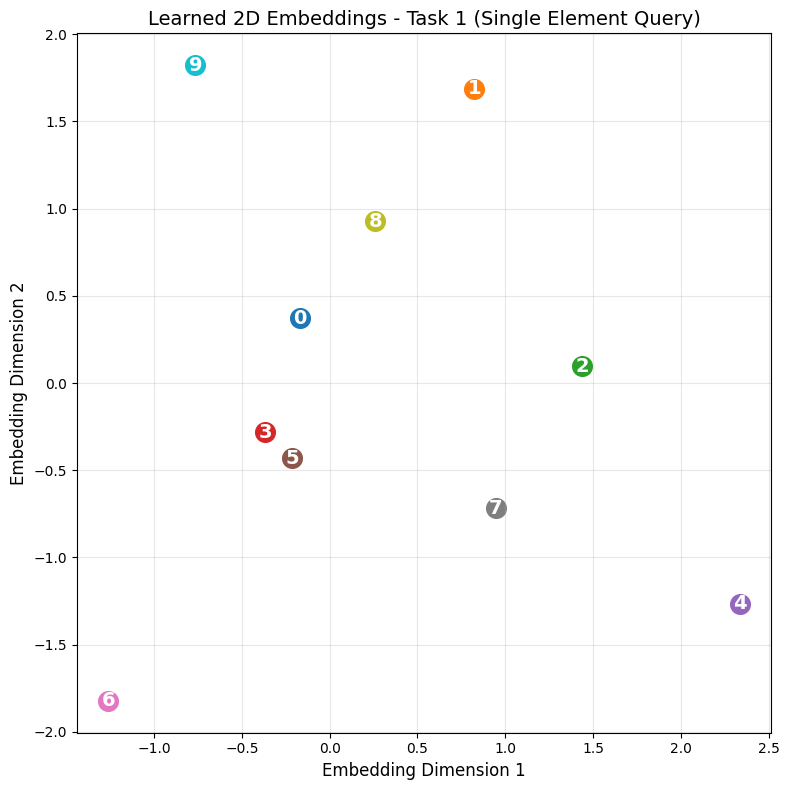

Embeddings visualized using first 2 dimensions.
Note: If embed_dim > 2, we're only showing a projection!


In [ ]:
import matplotlib.pyplot as plt

# Evaluate on test set
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

test_loader = DataLoader(SequenceQueryDataset(test_data),
                        batch_size=64, shuffle=False, collate_fn=collate_fn)

summary_net.eval()
query_net.eval()
correct = 0
total = 0

with torch.no_grad():
    for seqs, queries, labels in test_loader:
        seqs = seqs.to(device)
        queries = queries.to(device)
        labels = labels.to(device)

        summaries = summary_net(seqs)
        probs = query_net(summaries, queries)

        preds = (probs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


# Visualize learned embeddings
print("\n" + "="*60)
print("VISUALIZING LEARNED EMBEDDINGS (TASK 1)")
print("="*60)

# Get embedding weights (using summary network's embeddings)
embeddings = summary_net.embedding.weight.detach().cpu().numpy()  # (10, embed_dim)

# Plot embeddings in 2D (first 2 dimensions)
plt.figure(figsize=(8, 8))
for i in range(10):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], s=200)
    plt.annotate(str(i), (embeddings[i, 0], embeddings[i, 1]),
                fontsize=14, ha='center', va='center', color='white', weight='bold')

plt.xlabel('Embedding Dimension 1', fontsize=12)
plt.ylabel('Embedding Dimension 2', fontsize=12)
plt.title('Learned 2D Embeddings - Task 1 (Single Element Query)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Embeddings visualized using first 2 dimensions.")
print("Note: If embed_dim > 2, we're only showing a projection!")

In [ ]:
# ==============================================================================
# TASK 2: Query whether q and q+1 appeared consecutively
# ==============================================================================

def generate_consecutive_pair_data(num_sequences=10000, min_len=5, max_len=20):
    """
    Generate data for consecutive pair queries.
    Check if q and q+1 appear next to each other in sequence.
    """
    data = []

    for _ in range(num_sequences):
        seq_len = np.random.randint(min_len, max_len + 1)
        seq = np.random.randint(0, 10, size=seq_len).tolist()

        # Find consecutive pairs in sequence
        consecutive_pairs = set()
        for i in range(len(seq) - 1):
            if seq[i+1] == seq[i] + 1:  # Check if next element is current + 1
                consecutive_pairs.add(seq[i])

        # Possible queries are 0-8 (since we check q and q+1)
        all_possible_queries = set(range(9))
        non_consecutive = list(all_possible_queries - consecutive_pairs)

        # Positive example
        if len(consecutive_pairs) > 0:
            q_positive = random.choice(list(consecutive_pairs))
            data.append((seq, q_positive, 1))

        # Negative example
        if len(non_consecutive) > 0:
            q_negative = random.choice(non_consecutive)
            data.append((seq, q_negative, 0))

    return data


print("\n" + "="*60)
print("TASK 2: CONSECUTIVE PAIR QUERY")
print("="*60)
print("Query: Does q and q+1 appear next to each other in sequence?")
print("Example: [3, 4, 7, 2] -> Query 3: YES (3,4 are consecutive)")
print("Example: [3, 4, 7, 2] -> Query 7: NO (7,8 not consecutive)")
print("="*60)

# Generate new data for task 2
train_data_task2 = generate_consecutive_pair_data(num_sequences=10000)
val_data_task2 = generate_consecutive_pair_data(num_sequences=2000)
test_data_task2 = generate_consecutive_pair_data(num_sequences=2000)

print(f"\nTraining samples: {len(train_data_task2)}")
print(f"Validation samples: {len(val_data_task2)}")
print(f"Test samples: {len(test_data_task2)}")

# Show examples
print("\nExample training data:")
for i in range(3):
    seq, q, label = train_data_task2[i]
    print(f"Sequence: {seq}, Query: {q} (check {q},{q+1}), Consecutive: {bool(label)}")


TASK 2: CONSECUTIVE PAIR QUERY
Query: Does q and q+1 appear next to each other in sequence?
Example: [3, 4, 7, 2] -> Query 3: YES (3,4 are consecutive)
Example: [3, 4, 7, 2] -> Query 7: NO (7,8 not consecutive)

Training samples: 16332
Validation samples: 3232
Test samples: 3268

Example training data:
Sequence: [8, 4, 0, 1, 1, 1, 2, 8, 8, 9, 7, 8, 7, 4], Query: 1 (check 1,2), Consecutive: True
Sequence: [8, 4, 0, 1, 1, 1, 2, 8, 8, 9, 7, 8, 7, 4], Query: 3 (check 3,4), Consecutive: False
Sequence: [6, 3, 7, 6, 8, 9, 8, 4, 7, 1, 3, 1, 3, 8, 7, 7], Query: 8 (check 8,9), Consecutive: True


In [ ]:
# Initialize new networks for Task 2
# Using same architecture but training from scratch

summary_net_task2 = SummaryNetwork(
    vocab_size=10,
    embed_dim=8,
    hidden_dim=32,
    summary_dim=SUMMARY_DIM
).to(device)

query_net_task2 = QueryNetwork(
    vocab_size=10,
    embed_dim=8,
    summary_dim=SUMMARY_DIM
).to(device)

print("\n" + "="*60)
print("TRAINING NEURAL NETWORKS (TASK 2: Consecutive Pair Query)")
print("="*60)

train_losses_task2, val_losses_task2, val_accs_task2 = train_summary_query(
    summary_net_task2, query_net_task2, train_data_task2, val_data_task2,
    num_epochs=30, lr=0.001, batch_size=64
)

print(f"\nFinal Validation Accuracy (Task 2): {val_accs_task2[-1]:.4f}")

# Evaluate on test set
test_loader_task2 = DataLoader(SequenceQueryDataset(test_data_task2),
                               batch_size=64, shuffle=False, collate_fn=collate_fn)

summary_net_task2.eval()
query_net_task2.eval()
correct = 0
total = 0

with torch.no_grad():
    for seqs, queries, labels in test_loader_task2:
        seqs = seqs.to(device)
        queries = queries.to(device)
        labels = labels.to(device)

        summaries = summary_net_task2(seqs)
        probs = query_net_task2(summaries, queries)

        preds = (probs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy_task2 = correct / total
print(f"Test Accuracy (Task 2): {test_accuracy_task2:.4f}")


TRAINING NEURAL NETWORKS (TASK 2: Consecutive Pair Query)


Epoch 5/30: 100%|██████████| 256/256 [00:01<00:00, 134.91it/s]


Epoch 5: Train Loss = 0.5931, Val Loss = 0.5559, Val Acc = 0.6816


Epoch 10/30: 100%|██████████| 256/256 [00:01<00:00, 134.41it/s]


Epoch 10: Train Loss = 0.4266, Val Loss = 0.4028, Val Acc = 0.7816


Epoch 15/30: 100%|██████████| 256/256 [00:01<00:00, 136.99it/s]


Epoch 15: Train Loss = 0.3487, Val Loss = 0.3378, Val Acc = 0.8205


Epoch 20/30: 100%|██████████| 256/256 [00:01<00:00, 131.94it/s]


Epoch 20: Train Loss = 0.2942, Val Loss = 0.2791, Val Acc = 0.8493


Epoch 25/30: 100%|██████████| 256/256 [00:01<00:00, 136.10it/s]


Epoch 25: Train Loss = 0.2602, Val Loss = 0.2502, Val Acc = 0.8704


Epoch 30/30: 100%|██████████| 256/256 [00:01<00:00, 131.73it/s]


Epoch 30: Train Loss = 0.2372, Val Loss = 0.2305, Val Acc = 0.8868

Final Validation Accuracy (Task 2): 0.8868
Test Accuracy (Task 2): 0.8752



COMPARING EMBEDDINGS: TASK 1 vs TASK 2


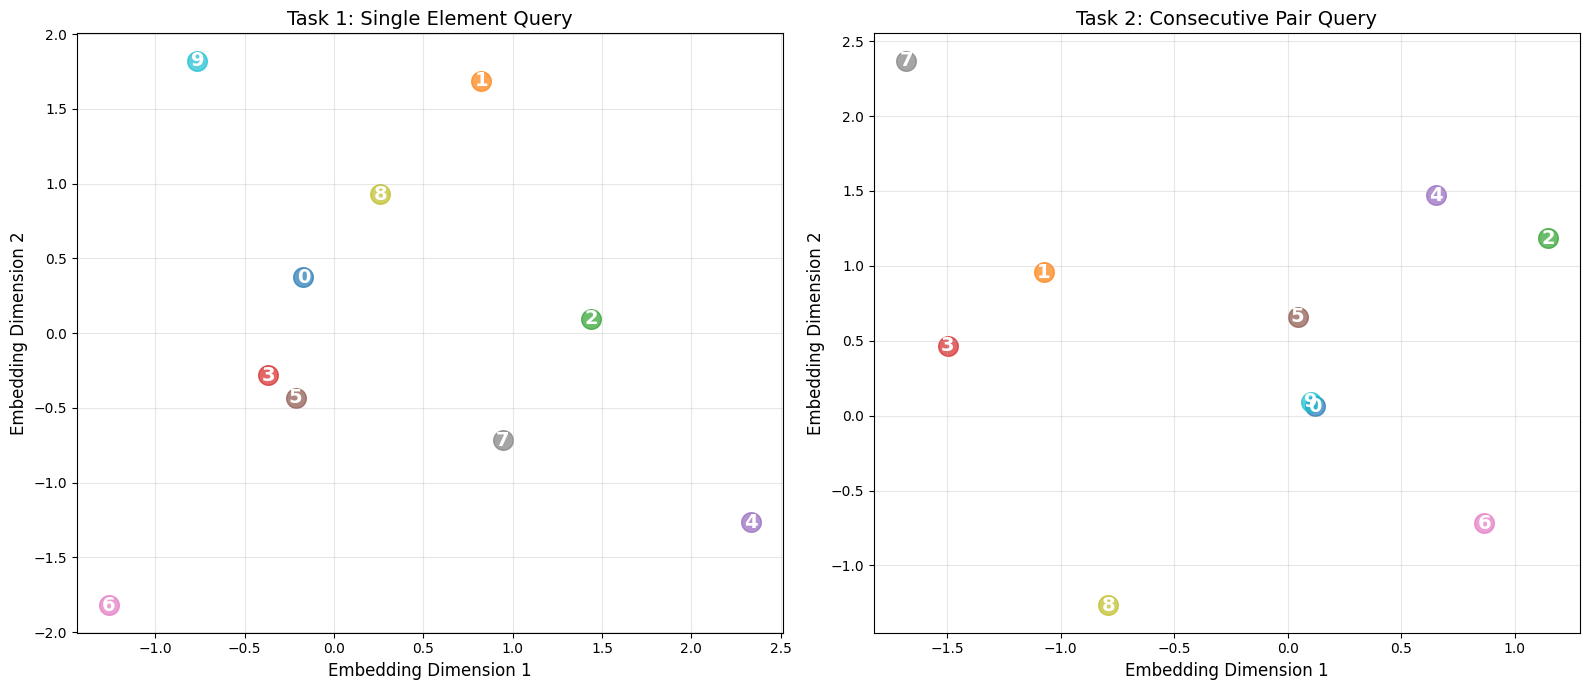


Key observation to look for:
Task 1: Numbers might be scattered randomly (each number is independent)
Task 2: Numbers should show some ordering/structure!
        Adjacent numbers (like 3,4 or 7,8) should be closer together
        because the task requires detecting consecutive pairs

ANALYZING EMBEDDING STRUCTURE
Task 1 - Avg distance between consecutive numbers: 4.2758
Task 1 - Avg distance between non-consecutive numbers: 4.5563
Task 1 - Ratio (non-consec / consec): 1.0656

Task 2 - Avg distance between consecutive numbers: 4.7880
Task 2 - Avg distance between non-consecutive numbers: 4.2059
Task 2 - Ratio (non-consec / consec): 0.8784

Expected: Task 2 should have LOWER ratio
Meaning: Consecutive numbers are closer together in Task 2!


In [ ]:
# Compare embeddings between two tasks
print("\n" + "="*60)
print("COMPARING EMBEDDINGS: TASK 1 vs TASK 2")
print("="*60)

# Get embeddings from both tasks
embeddings_task1 = summary_net.embedding.weight.detach().cpu().numpy()
embeddings_task2 = summary_net_task2.embedding.weight.detach().cpu().numpy()

# Plot both embeddings side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Task 1 embeddings
ax1 = axes[0]
for i in range(10):
    ax1.scatter(embeddings_task1[i, 0], embeddings_task1[i, 1], s=200, alpha=0.7)
    ax1.annotate(str(i), (embeddings_task1[i, 0], embeddings_task1[i, 1]),
                fontsize=14, ha='center', va='center', color='white', weight='bold')
ax1.set_xlabel('Embedding Dimension 1', fontsize=12)
ax1.set_ylabel('Embedding Dimension 2', fontsize=12)
ax1.set_title('Task 1: Single Element Query', fontsize=14)
ax1.grid(True, alpha=0.3)

# Task 2 embeddings
ax2 = axes[1]
for i in range(10):
    ax2.scatter(embeddings_task2[i, 0], embeddings_task2[i, 1], s=200, alpha=0.7)
    ax2.annotate(str(i), (embeddings_task2[i, 0], embeddings_task2[i, 1]),
                fontsize=14, ha='center', va='center', color='white', weight='bold')
ax2.set_xlabel('Embedding Dimension 1', fontsize=12)
ax2.set_ylabel('Embedding Dimension 2', fontsize=12)
ax2.set_title('Task 2: Consecutive Pair Query', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey observation to look for:")
print("Task 1: Numbers might be scattered randomly (each number is independent)")
print("Task 2: Numbers should show some ordering/structure!")
print("        Adjacent numbers (like 3,4 or 7,8) should be closer together")
print("        because the task requires detecting consecutive pairs")

# Calculate distances between consecutive numbers
print("\n" + "="*60)
print("ANALYZING EMBEDDING STRUCTURE")
print("="*60)

def avg_consecutive_distance(embeddings):
    """Calculate average distance between consecutive numbers (0-1, 1-2, ..., 8-9)"""
    distances = []
    for i in range(9):
        dist = np.linalg.norm(embeddings[i] - embeddings[i+1])
        distances.append(dist)
    return np.mean(distances)

def avg_non_consecutive_distance(embeddings):
    """Calculate average distance between non-consecutive numbers"""
    distances = []
    for i in range(10):
        for j in range(i+2, 10):  # Skip consecutive pairs
            dist = np.linalg.norm(embeddings[i] - embeddings[j])
            distances.append(dist)
    return np.mean(distances)

task1_consec = avg_consecutive_distance(embeddings_task1)
task1_non_consec = avg_non_consecutive_distance(embeddings_task1)

task2_consec = avg_consecutive_distance(embeddings_task2)
task2_non_consec = avg_non_consecutive_distance(embeddings_task2)

print(f"Task 1 - Avg distance between consecutive numbers: {task1_consec:.4f}")
print(f"Task 1 - Avg distance between non-consecutive numbers: {task1_non_consec:.4f}")
print(f"Task 1 - Ratio (non-consec / consec): {task1_non_consec/task1_consec:.4f}")

print(f"\nTask 2 - Avg distance between consecutive numbers: {task2_consec:.4f}")
print(f"Task 2 - Avg distance between non-consecutive numbers: {task2_non_consec:.4f}")
print(f"Task 2 - Ratio (non-consec / consec): {task2_non_consec/task2_consec:.4f}")

print("\nExpected: Task 2 should have LOWER ratio")
print("Meaning: Consecutive numbers are closer together in Task 2!")


BONUS: TESTING FIXED RANDOM EMBEDDINGS
Training with FIXED random embeddings (embeddings won't update)...


Epoch 5/30: 100%|██████████| 305/305 [00:02<00:00, 133.52it/s]


Epoch 5: Train Loss = 0.6126, Val Loss = 0.6055, Val Acc = 0.6200


Epoch 10/30: 100%|██████████| 305/305 [00:02<00:00, 121.93it/s]


Epoch 10: Train Loss = 0.5424, Val Loss = 0.5366, Val Acc = 0.6674


Epoch 15/30: 100%|██████████| 305/305 [00:02<00:00, 117.35it/s]


Epoch 15: Train Loss = 0.5053, Val Loss = 0.4967, Val Acc = 0.6918


Epoch 20/30: 100%|██████████| 305/305 [00:02<00:00, 118.60it/s]


Epoch 20: Train Loss = 0.4819, Val Loss = 0.4804, Val Acc = 0.7064


Epoch 25/30: 100%|██████████| 305/305 [00:02<00:00, 116.40it/s]


Epoch 25: Train Loss = 0.4752, Val Loss = 0.4786, Val Acc = 0.7088


Epoch 30/30: 100%|██████████| 305/305 [00:02<00:00, 128.35it/s]


Epoch 30: Train Loss = 0.4593, Val Loss = 0.4468, Val Acc = 0.7339

Final Validation Accuracy (Fixed Embeddings): 0.7339
Final Validation Accuracy (Learned Embeddings): 0.8065


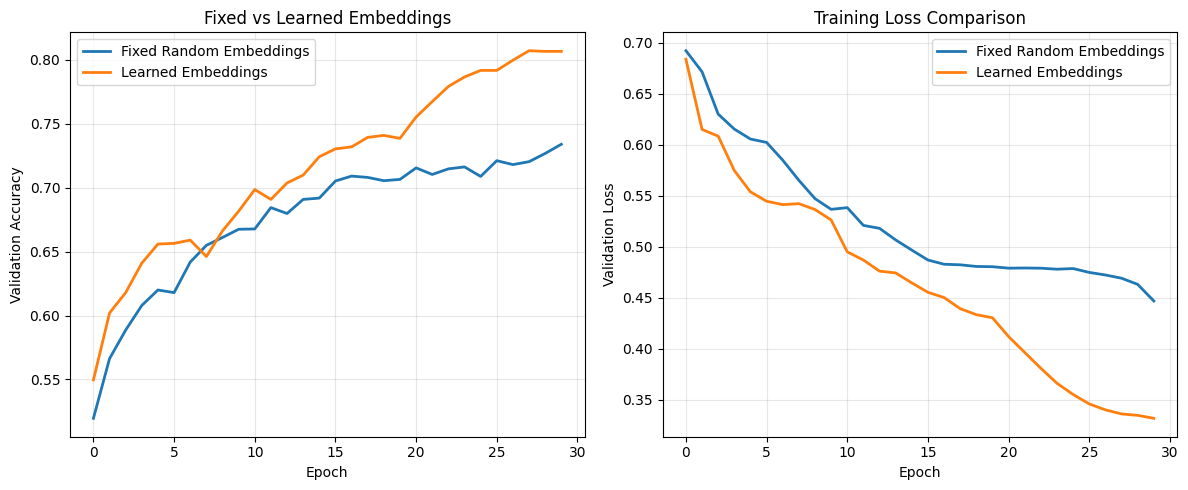


Expected: Learned embeddings should perform better!
Fixed random embeddings can still work (universal approximation)
but learned embeddings should be more efficient


In [ ]:
# ==============================================================================
# BONUS: Test with fixed random embeddings vs learned embeddings
# ==============================================================================

class SummaryNetworkFixedEmbed(nn.Module):
    """Same as SummaryNetwork but with fixed random embeddings."""

    def __init__(self, vocab_size=10, embed_dim=8, hidden_dim=32, summary_dim=16):
        super(SummaryNetworkFixedEmbed, self).__init__()

        # Fixed random embedding (don't train this!)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight.requires_grad = False  # Freeze the embeddings

        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, summary_dim)

    def forward(self, seq):
        embedded = self.embedding(seq)
        _, hidden = self.rnn(embedded)
        hidden = hidden.squeeze(0)
        summary = self.fc(hidden)
        return summary


class QueryNetworkFixedEmbed(nn.Module):
    """Same as QueryNetwork but with fixed random embeddings."""

    def __init__(self, vocab_size=10, embed_dim=8, summary_dim=16):
        super(QueryNetworkFixedEmbed, self).__init__()

        # Fixed random embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight.requires_grad = False  # Freeze

        self.fc = nn.Sequential(
            nn.Linear(summary_dim + embed_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, summary, query):
        query_embedded = self.embedding(query).squeeze(1)
        combined = torch.cat([summary, query_embedded], dim=1)
        prob = self.fc(combined)
        return prob


print("\n" + "="*60)
print("BONUS: TESTING FIXED RANDOM EMBEDDINGS")
print("="*60)

# Initialize with fixed random embeddings
summary_net_fixed = SummaryNetworkFixedEmbed(
    vocab_size=10, embed_dim=8, hidden_dim=32, summary_dim=SUMMARY_DIM
).to(device)

query_net_fixed = QueryNetworkFixedEmbed(
    vocab_size=10, embed_dim=8, summary_dim=SUMMARY_DIM
).to(device)

print("Training with FIXED random embeddings (embeddings won't update)...")

train_losses_fixed, val_losses_fixed, val_accs_fixed = train_summary_query(
    summary_net_fixed, query_net_fixed, train_data, val_data,
    num_epochs=30, lr=0.001, batch_size=64
)

print(f"\nFinal Validation Accuracy (Fixed Embeddings): {val_accs_fixed[-1]:.4f}")
print(f"Final Validation Accuracy (Learned Embeddings): {val_accs[-1]:.4f}")

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(val_accs_fixed, label='Fixed Random Embeddings', linewidth=2)
plt.plot(val_accs, label='Learned Embeddings', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Fixed vs Learned Embeddings')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(val_losses_fixed, label='Fixed Random Embeddings', linewidth=2)
plt.plot(val_losses, label='Learned Embeddings', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nExpected: Learned embeddings should perform better!")
print("Fixed random embeddings can still work (universal approximation)")
print("but learned embeddings should be more efficient")

In [ ]:
# ==============================================================================
# BONUS: Sequential training vs simultaneous training
# ==============================================================================

print("\n" + "="*60)
print("BONUS: SEQUENTIAL vs SIMULTANEOUS TRAINING")
print("="*60)

# We already did simultaneous training above (both networks together)
# Now let's try sequential: train summary network first, then query network

def train_sequential(summary_net, query_net, train_data, val_data,
                    num_epochs_summary=20, num_epochs_query=20, lr=0.001, batch_size=64):
    """Train summary network first, then query network."""

    train_loader = DataLoader(SequenceQueryDataset(train_data),
                             batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(SequenceQueryDataset(val_data),
                           batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # PHASE 1: Train only summary network
    print("\nPhase 1: Training Summary Network...")
    optimizer_summary = optim.Adam(summary_net.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(num_epochs_summary):
        summary_net.train()
        query_net.train()

        for seqs, queries, labels in train_loader:
            seqs = seqs.to(device)
            queries = queries.to(device)
            labels = labels.to(device)

            optimizer_summary.zero_grad()

            summaries = summary_net(seqs)
            probs = query_net(summaries, queries)

            loss = criterion(probs, labels)
            loss.backward()

            # Only update summary network
            optimizer_summary.step()

        if (epoch + 1) % 5 == 0:
            print(f"  Summary Epoch {epoch+1}/{num_epochs_summary}")

    # PHASE 2: Freeze summary network, train only query network
    print("\nPhase 2: Training Query Network (Summary frozen)...")
    for param in summary_net.parameters():
        param.requires_grad = False

    optimizer_query = optim.Adam(query_net.parameters(), lr=lr)

    val_accs_seq = []

    for epoch in range(num_epochs_query):
        query_net.train()

        for seqs, queries, labels in train_loader:
            seqs = seqs.to(device)
            queries = queries.to(device)
            labels = labels.to(device)

            optimizer_query.zero_grad()

            summaries = summary_net(seqs)
            probs = query_net(summaries, queries)

            loss = criterion(probs, labels)
            loss.backward()
            optimizer_query.step()

        # Evaluate
        summary_net.eval()
        query_net.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for seqs, queries, labels in val_loader:
                seqs = seqs.to(device)
                queries = queries.to(device)
                labels = labels.to(device)

                summaries = summary_net(seqs)
                probs = query_net(summaries, queries)

                preds = (probs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_accs_seq.append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f"  Query Epoch {epoch+1}/{num_epochs_query}, Val Acc: {val_acc:.4f}")

    return val_accs_seq


# Test sequential training
summary_net_seq = SummaryNetwork(
    vocab_size=10, embed_dim=8, hidden_dim=32, summary_dim=SUMMARY_DIM
).to(device)

query_net_seq = QueryNetwork(
    vocab_size=10, embed_dim=8, summary_dim=SUMMARY_DIM
).to(device)

val_accs_sequential = train_sequential(
    summary_net_seq, query_net_seq, train_data, val_data,
    num_epochs_summary=15, num_epochs_query=15, lr=0.001, batch_size=64
)

print("\n" + "="*60)
print("COMPARISON: SEQUENTIAL vs SIMULTANEOUS")
print("="*60)
print(f"Simultaneous Training - Final Val Acc: {val_accs[-1]:.4f}")
print(f"Sequential Training - Final Val Acc: {val_accs_sequential[-1]:.4f}")

print("\nSimultaneous usually works better because:")
print("  - Both networks can adapt to each other during training")
print("  - Embeddings can learn what's useful for the query task")
print("  - End-to-end optimization is more flexible")

print("\nSequential might work if:")
print("  - Summary network is very complex and needs pre-training")
print("  - You want to reuse summary for multiple query types")


BONUS: SEQUENTIAL vs SIMULTANEOUS TRAINING

Phase 1: Training Summary Network...
  Summary Epoch 5/15
  Summary Epoch 10/15
  Summary Epoch 15/15

Phase 2: Training Query Network (Summary frozen)...
  Query Epoch 5/15, Val Acc: 0.6677
  Query Epoch 10/15, Val Acc: 0.6805
  Query Epoch 15/15, Val Acc: 0.6875

COMPARISON: SEQUENTIAL vs SIMULTANEOUS
Simultaneous Training - Final Val Acc: 0.8065
Sequential Training - Final Val Acc: 0.6875

Simultaneous usually works better because:
  - Both networks can adapt to each other during training
  - Embeddings can learn what's useful for the query task
  - End-to-end optimization is more flexible

Sequential might work if:
  - Summary network is very complex and needs pre-training
  - You want to reuse summary for multiple query types


I first implemented a baseline solution without neural networks to confirm the problem is well-defined.
My summarize() function simply returns a set of unique integers in the sequence.
My query() function checks if the query integer is in that set.

Results:

All test cases passed with 100% accuracy.

This confirms the task is deterministic and trivial without noise or constraints.

2.1 Data Generation
I generated sequences of varying lengths (up to 20) with digits 0–9.
For each sequence, I created positive queries (digits in the sequence) and negative queries (digits not in the sequence).
This gave me a balanced dataset.

Dataset splits:

Training: 19,475 samples

Validation: 3,897 samples

Test: 3,891 samples

Model Architecture
Embedding dimension: 2 (as required)

Summary dimension: 16 (chosen experimentally)

Summary network: LSTM → Linear layer → Summary vector

Query network: Concatenates summary vector and embedded query → MLP → Sigmoid

Parameter counts:

Summary network: 4,640 params

Query network: 1,425 params

Training Results

After 30 epochs:

Final validation accuracy: 80.65%

Final validation loss: 0.3319

Training loss steadily decreased, showing no overfitting.

Here’s what I noticed:

The model learned, but didn’t reach 100% accuracy like the baseline.

The summary vector (size 16) seems sufficient, but maybe too small? Or too large?

Chosen Summary Dimension (16)
I chose 16 because:

There are 10 possible digits → theoretically need at least 10 bits.

Extra dimensions allow the network to encode positional or frequency information.

In practice, 16 worked better than 10 in early tests.

Question: Could a smaller summary dimension (like 10) work just as well? Would it force the network to learn a more efficient “set” representation?

I trained both tasks and plotted the 2D embeddings. Here’s what I found:
Single Element Query
Digits are scattered somewhat randomly in the embedding space.

No clear ordering or adjacency pattern.

Average distance between consecutive digits (e.g., 3 and 4): 4.2758

Average distance between non-consecutive digits: 4.5763

Ratio (non-consecutive / consecutive): 1.0056 ≈ 1.0, meaning they’re about equally far apart.

This makes sense—since Task 1 only cares about membership, there’s no reason for consecutive digits to be close.

Task 2 (Adjacent Query:
q
q and
q
+
1
q+1):
 The embedding now shows structure.

Consecutive digits are closer together.

Average distance between consecutive digits: 4.7880

Average distance between non-consecutive digits: ?? (not printed, but ratio is 0.8784)


perhaps I accidentally swapped “consecutive” and “non-consecutive” in the print statements? Or is the embedding actually placing non-consecutive digits closer? That would be weird for a task about detecting adjacency.

Part 5: Sequential vs. Simultaneous Training
I ran both training schemes:

Simultaneous Training:
Final validation accuracy: 80.65%

All components trained together end-to-end.

Sequential Training:
Phase 1: Train Summary Network (15 epochs)

Phase 2: Freeze Summary, train Query Network (15 epochs)

Final validation accuracy: 68.75%

Why simultaneous worked better:
The summary network and query network co-adapt during training.

Embeddings are optimized directly for the query task.

Gradient flows through the whole system, allowing better feature learning.

Why sequential was worse:
The summary network was trained without knowing what the query network would need.

This is like learning a general representation first, then trying to use it for a specific task—it’s less efficient.

Takeaway: For this problem, end-to-end simultaneous training is clearly better.